In [1]:
import os
import glob
import numpy as np
import pandas as pd

from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib


from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import cross_val_predict, StratifiedKFold, cross_val_score, permutation_test_score
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, pairwise_distances
from imblearn.over_sampling import SMOTE 

%matplotlib inline

In [117]:
roi_name = '7Networks_LH_Default_PFC_8'
sub_list = list(range(13, 51))
run_list = [1,2,3,4,5,6]
sub_list.remove(21)
n_groups, remaining_cols = 24, 53
results = []
for sub in sub_list:
    # brain date
    brain_data = []  
    for run in run_list:
        pattern_file = f'/Users/li/Desktop/debate/braindata/denoised 6/ROI Spatial Pattern/7Networks_LH_Default_PFC_8/sub-0{sub}/sub-0{sub}_run-{run}_7Networks_LH_Default_PFC_8_voxel_time_series.npy'
        run_data = np.load(pattern_file) 
        brain_data.append(run_data) 
    brain_data = np.concatenate(brain_data, axis=1)
    # 计算每组的平均值
    brain_data_reshaped = brain_data[:, :n_groups * 60].reshape(644, n_groups, 60)
    brain_data_avg = brain_data_reshaped.mean(axis=2)
    
    # 如果有剩余列，不足60列的部分也计算平均
    if remaining_cols > 0:
        remaining_data = brain_data[:, -remaining_cols:]
        remaining_avg = remaining_data.mean(axis=1, keepdims=True)
        brain_data_avg = np.concatenate((brain_data_avg, remaining_avg), axis=1)

    results.append(brain_data_avg)
        
subs_mvp = np.array(results)

subs_mvp.shape

(37, 644, 25)

In [85]:

## 态度变化
bahav_data_dir = '/Users/li/Desktop/task-debate/behavdata'
sub_list_num = list(range(13,51))
sub_list_num.remove(21)

time_points = list(range(0,3000,120)) + [2986] # every 2min



all_subject_data = []
for sub in sub_list_num:
    file_path = os.path.join(bahav_data_dir, 'during_scan', 'combined_6runs_per_TR_filter', f'subject_{sub}_TR_rate.csv')
    
    df = pd.read_csv(file_path)
    sub_data = df[df['time'].isin(time_points)]
    all_subject_data.append(list(sub_data['rate']))
    
attitude = pd.DataFrame(all_subject_data) 
attitude_change = attitude.diff(axis=1)
attitude_change = attitude_change.drop(attitude_change.columns[0], axis=1)
attitude_change = np.array(attitude_change)


In [101]:
attitude_np = []
for sub in sub_list_num:
    file_path = os.path.join(bahav_data_dir, 'during_scan', 'combined_6runs_per_TR_filter', f'subject_{sub}_TR_rate.csv')
    df = pd.read_csv(file_path)
    attitude_np.append(list(df['rate']))
attitude_np = np.array(attitude_np)

# 用每行的最后一个数补齐到1500列
last_values = attitude_np[:, -1][:, np.newaxis]  # 取每行最后一个数，形状 (37, 1)
padding = np.repeat(last_values, 6, axis=1)  # 重复6次，形状 (37, 6)
data_padded = np.concatenate([attitude_np, padding], axis=1)  # 连接，得到 (37, 1500)

# 重新reshape成 (37, 25, 60)
data_reshaped = data_padded.reshape(37, 25, 60)

# 判断每组是不是所有元素一样（最大值 == 最小值）
change_result = (np.max(data_reshaped, axis=2) != np.min(data_reshaped, axis=2)).astype(int)

# result 的形状是 (37, 25)

change_result.shape

(37, 25)

In [103]:

data = []

# 遍历每个被试的25次态度变化
for i in range(attitude_change.shape[0]): 
    for t in range(attitude_change.shape[1]):  
        attitude_value = attitude_change[i, t]
        if_change = change_result[i, t]
        mvp_values = subs_mvp[i, :, t]
        row = [i + 1, t + 1, attitude_value, if_change] + mvp_values.tolist() 
        data.append(row)
columns = ['SubjectID', 'SegIndex', 'AttitudeChange', 'Change'] + [f'voxel_{j+1}' for j in range(subs_mvp.shape[1])]

df = pd.DataFrame(data, columns=columns)

print(df.shape)
df.head()

(925, 648)


,SubjectID,SegIndex,AttitudeChange,Change,voxel_1,voxel_2,voxel_3,voxel_4,voxel_5,voxel_6,...,voxel_635,voxel_636,voxel_637,voxel_638,voxel_639,voxel_640,voxel_641,voxel_642,voxel_643,voxel_644
0,1,1,0,0,-0.038860,-0.071841,0.036684,0.007936,-0.038846,0.074566,...,-0.014633,-0.034752,-0.080079,-0.122782,-0.141406,-0.149999,0.022685,-0.001131,-0.140569,-0.140691
1,1,2,0,0,0.149921,0.180307,0.063294,0.076277,0.099761,0.017908,...,0.129308,0.200252,0.237562,0.246082,0.220589,0.186164,0.128769,0.167051,0.193997,0.145933
2,1,3,0,0,-0.051001,-0.059751,-0.039753,-0.034881,-0.030823,-0.039464,...,-0.035764,-0.081905,-0.073598,-0.042094,-0.010770,-0.004918,-0.047725,-0.065238,-0.012476,0.000695
3,1,4,1,1,-0.058345,-0.072176,-0.021847,-0.027935,-0.044408,0.022551,...,-0.040728,-0.071855,-0.111389,-0.141094,-0.152046,-0.144545,-0.070879,-0.088807,-0.119410,-0.100469
4,1,5,0,0,0.042158,0.036463,0.044411,0.026481,0.016364,-0.001960,...,0.102956,0.113803,0.111219,0.093048,0.071439,0.049586,0.136360,0.149715,0.058136,0.030229


In [107]:
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import permutation_test_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

df_expanded = df.copy() 
X = df_expanded.drop(columns=['SubjectID', 'SegIndex', 'AttitudeChange', 'Change'])
y = df_expanded['Change']  
svm_model = SVC(class_weight='balanced')

# 进行置换检验
score, permutation_scores, pvalue = permutation_test_score(
    svm_model, X, y, cv=kfold, n_permutations=1000, n_jobs=-1, scoring="accuracy", random_state=42)

# 输出置换检验得分和p值
print(f"置换检验得分: {score:.2f}")
print(f"置换检验的p值: {pvalue:.4f}")

# 使用交叉验证进行预测
y_pred = cross_val_predict(svm_model, X, y, cv=loo)
accuracy = accuracy_score(y, y_pred)
print("loo正确率：", accuracy)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y, y_pred)
print("混淆矩阵:")
print(conf_matrix)

# 输出分类报告
print("分类报告:")
print(classification_report(y, y_pred))

# 可视化置换检验结果
plt.hist(permutation_scores, bins=20, alpha=0.75, color='blue', label='Permutation Scores')
plt.axvline(accuracy, color='red', linestyle='--', linewidth=2, label=f'Actual Score ({score:.2f})')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')
plt.title('Permutation Test Results')
plt.legend(loc='best')
plt.show()


置换检验得分: 0.59
置换检验的p值: 0.0010
loo正确率： 0.6064864864864865
混淆矩阵:
[[250 226]
 [138 311]]
分类报告:
              precision    recall  f1-score   support

           0       0.64      0.53      0.58       476
           1       0.58      0.69      0.63       449

    accuracy                           0.61       925
   macro avg       0.61      0.61      0.60       925
weighted avg       0.61      0.61      0.60       925



AttributeError: module 'matplotlib.pyplot' has no attribute 'xla'

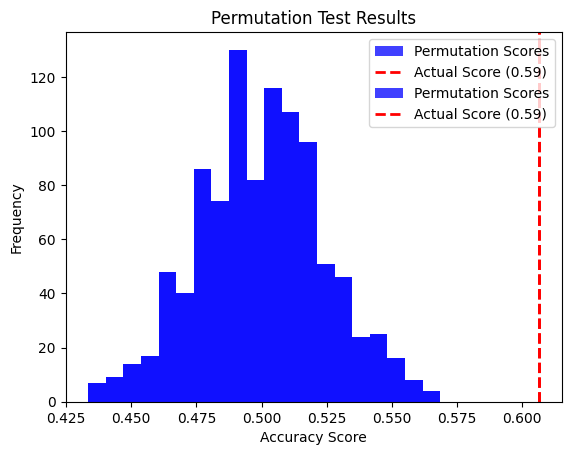

In [109]:
plt.hist(permutation_scores, bins=20, alpha=0.75, color='blue', label='Permutation Scores')
plt.axvline(accuracy, color='red', linestyle='--', linewidth=2, label=f'Actual Score ({score:.2f})')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')
plt.title('Permutation Test Results')
plt.legend(loc='best')
plt.show()


In [111]:

df_expanded = df.copy() 
X = df_expanded.drop(columns=['SubjectID', 'SegIndex', 'AttitudeChange', 'Change'])
y = df_expanded['Change']  
svm_model = SVC(class_weight='balanced')

# 进行PCA降维，保留95%的方差
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
print(X_pca.shape)
y_pred = cross_val_predict(svm_model, X_pca, y, cv=loo)
accuracy = accuracy_score(y, y_pred)
print("loo正确率：", accuracy)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y, y_pred)
print("混淆矩阵:")
print(conf_matrix)

# 输出分类报告
print("分类报告:")
print(classification_report(y, y_pred))


loo正确率： 0.6064864864864865
混淆矩阵:
[[250 226]
 [138 311]]
分类报告:
              precision    recall  f1-score   support

           0       0.64      0.53      0.58       476
           1       0.58      0.69      0.63       449

    accuracy                           0.61       925
   macro avg       0.61      0.61      0.60       925
weighted avg       0.61      0.61      0.60       925



In [113]:
X_pca.shape

(925, 8)